In [13]:
#Use Environment py36
import pandas as pd
from geopy.distance import VincentyDistance
from math import radians, cos, sin, asin, sqrt
import geopy
import datetime
AVG_EARTH_RADIUS = 6371000 # meters
df = pd.read_csv('output_cleaned.csv')
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S.%f')

In [7]:
#https://gist.github.com/JesseCrocker/9c4b8e334ceba63f3d08
def haversine_distance(point1, point2):
    lat1, lng1 = point1[:2]
    lat2, lng2 = point2[:2]

    # convert all latitudes/longitudes from decimal degrees to radians
    lat1, lng1, lat2, lng2 = list(map(radians, [lat1, lng1, lat2, lng2]))

    # calculate haversine
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = sin(lat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(lng / 2) ** 2
    return 2 * AVG_EARTH_RADIUS * asin(sqrt(d))

def get_time_for_point(points, input_gps, interpolate=False, min_closest_distance=2000):
    """Get location for time, interpolating between points if necesary
    returns (x, y, z)
    """

    subset = points[['lat', 'lon', 'time']]
    segment = [tuple(x) for x in subset.values]
    points = segment

    closest_distance = None
    closest_index = None
    closest_point = None
    for i in (range(0, len(points))):
        p = points[i]
        d = haversine_distance(p, input_gps)
    #     print(t)
        if d < min_closest_distance and (closest_distance is None or d < closest_distance):
            closest_distance = d
            closest_index = i
            closest_point = p

#         print(closest_point)
    print(closest_index)
    if interpolate and closest_point is not None:
        if closest_index > 0 and closest_index < len(points) - 1:
            before_d, d, after_d = [haversine_distance(points[closest_index + i], input_gps) for i in (-1,0,1)]
            if before_d < after_d:
                b = points[closest_index - 1]
                before = True
            else:
                b = points[closest_index + 1]
                before = False
            print(before)
            if(before):
                time_fraction = (before_d)/(before_d + d)
                print("before_time:", points[closest_index - 1][2])
                proj_time = points[closest_index - 1][2] + (points[closest_index][2]-points[closest_index - 1][2])*time_fraction
                print("proj_time:",proj_time)
                print("after_time:", points[closest_index][2])

            else:
                time_fraction = (d)/(after_d + d)
                print("before_time:",points[closest_index][2])
                proj_time = points[closest_index][2] + (points[closest_index + 1][2]-points[closest_index][2])*time_fraction
                print("proj_time:",proj_time)
                print("after_time:",points[closest_index + 1][2])
        if(closest_index == 0 or closest_index == len(points) - 1):
            return closest_point, points[closest_index][2] 
        if(proj_time):
            return closest_point, proj_time
        else:
            return closest_point, None

    else:
        if(closest_point):
            proj_time = points[closest_index][2]
            return closest_point, proj_time
        else:
            return None, None
    

# interpolate = True
# min_closest_distance=2000
# points = one_trip
# clos, p_time = get_time_for_point(points, input_gps, interpolate=True)
# # print(clos)
# print(p_time)

In [ ]:
import matplotlib.pyplot as plt
from time import mktime
import math

def time_since_epoch(date):
    #todo: i dont think this handles fractional seconds
    return mktime(date.timetuple())
def project_point(point, distance, bearing):
    origin = geopy.Point(point[0], point[1])
    destination = VincentyDistance(meters=distance).destination(origin, bearing)

    return destination.latitude, destination.longitude, 0, None
def calculate_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
 
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
 
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
 
    :Returns:
      The bearing in degrees
 
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")
 
    lat1 = math.radians(pointA[1])
    lat2 = math.radians(pointB[1])
 
    diffLong = math.radians(pointB[0] - pointA[0])
 
    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))
 
    initial_bearing = math.atan2(x, y)
 
    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360
 
    return compass_bearing

def get_point_for_time(points, date, interpolate=False, min_closest_time=60):
    """Get location for time, interpolating between points if necesary
    returns (x, y, z)
    """

    subset = points[['lat', 'lon', 'time']]
    segment = [tuple(x) for x in subset.values]
    points = segment

    closest_time = None
    closest_index = None
    closest_point = None
    for i in (range(0, len(points))):
        p = points[i]
        t = abs(p[2] - date)
    #     print(t)
        if t < datetime.timedelta(seconds=min_closest_time) and (closest_time is None or t < closest_time):
            closest_time = t
            closest_index = i
            closest_point = p
    print(closest_point)
    if interpolate and closest_point is not None:
        if closest_index > 0 and closest_index < len(points) - 1:
            before_t, t, after_t = [points[closest_index + i][2] - date for i in (-1,0,1)]
            if before_t < after_t:
                b = points[closest_index - 1]
            else:
                b = points[closest_index + 1]
            distance = haversine_distance(closest_point, b)
            time_difference = b[2] - date
            time_fraction = closest_time / time_difference
            distance = distance * time_fraction
            bearing = calculate_bearing(closest_point, b)

            projected = project_point(closest_point, distance, bearing)
            if projected is not None:
                closest_point = projected

    return closest_point, closest_time

k=13

date = one_trip['time'][k] + (one_trip['time'][k+1]-one_trip['time'][k])/2
# interpolate=True
# min_closest_time=100
print(date)
p, t = get_point_for_time(one_trip, date, interpolate=True, min_closest_time=60)

subset = one_trip[['lat', 'lon', 'time']]
segment = [tuple(x) for x in subset.values]
points = segment


plt.plot([x for x,y,z in points], [y for x,y,z in points], label='data')
plt.plot(p[0], p[1], 'ro')
plt.show()
input_gps = p
print("time input:")
print(date)
print(input_gps)
one_trip['time'][k] + (one_trip['time'][k+1]-one_trip['time'][k])/2
date = one_trip['time'][k] + (one_trip['time'][k+1]-one_trip['time'][k])/2
points[closest_index - 1][2] + (points[closest_index][2]-points[closest_index - 1][2])*(before_d)/(before_d + d)

In [23]:
params = pd.read_excel('GPS segments.xlsx')
params

FileNotFoundError: [Errno 2] No such file or directory: 'GPS segments.xlsx'

In [14]:
"""Provided a good input script, this function will estimate the time a vehicle arrived at a given Lat/Lng 
from gps data.
"""


trip_data = []
dates = df['time'].dt.date.unique()
for date in dates:
    for route in [901,902]:
        trips_to_check = df.query('route_short_name==%s' % route)['trip_id'].unique()
        for trip in trips_to_check:
            one_trip = df[ (df['time'].dt.date == date)].query('route_short_name==%s&direction_id==1&trip_id==%d' % (route, trip) )

            for i, r in params.iterrows():
                row_calc = {}
                row_calc['Station A'] = r['Station A']
                row_calc['Station B'] = r['Station B']
                row_calc['Direction'] = 1
                row_calc['trip_id'] = trip
                row_calc['Route'] = route
                row_calc['Date'] = date
                start_gps = geopy.Point(r['Lat A'], r['Long A'])
                end_gps = geopy.Point(r['Lat B'], r['Long B'])
                clos_start, start_p_time = get_time_for_point(one_trip, start_gps, interpolate=True)
                clos_end, end_p_time = get_time_for_point(one_trip, end_gps, interpolate=True)

                row_calc['clos_start'] = clos_start
                row_calc['clos_end'] = clos_end
                if(start_p_time and end_p_time):
                    row_calc['Start_p_time'] = datetime.datetime(start_p_time.year, start_p_time.month, start_p_time.day, start_p_time.hour, start_p_time.minute, start_p_time.second)
                    row_calc['End_p_time'] = datetime.datetime(end_p_time.year, end_p_time.month, end_p_time.day, end_p_time.hour, end_p_time.minute, end_p_time.second)
                    row_calc['est_trip_seconds'] = round((end_p_time - start_p_time).total_seconds(),2)
                trip_data.append(row_calc)
pd.DataFrame(trip_data)

901
3
True
before_time: 2017-05-02 16:11:02
after_time: 2017-05-02 16:11:32
6
False
before_time: 2017-05-02 16:13:02
after_time: 2017-05-02 16:13:32
9
True
before_time: 2017-05-02 16:14:02
after_time: 2017-05-02 16:14:32
16
False
before_time: 2017-05-02 16:18:12
after_time: 2017-05-02 16:18:42
17
True
before_time: 2017-05-02 16:18:12
after_time: 2017-05-02 16:18:42
20
True
before_time: 2017-05-02 16:19:42
after_time: 2017-05-02 16:20:22
20
False
before_time: 2017-05-02 16:20:22
after_time: 2017-05-02 16:20:52
23
True
before_time: 2017-05-02 16:21:22
after_time: 2017-05-02 16:21:52
23
False
before_time: 2017-05-02 16:21:52
after_time: 2017-05-02 16:22:22
26
False
before_time: 2017-05-02 16:23:22
after_time: 2017-05-02 16:23:53
27
True
before_time: 2017-05-02 16:23:22
after_time: 2017-05-02 16:23:53
29
False
before_time: 2017-05-02 16:24:53
after_time: 2017-05-02 16:25:33
29
False
before_time: 2017-05-02 16:24:53
after_time: 2017-05-02 16:25:33
32
False
before_time: 2017-05-02 16:26:33
a

,Date,Direction,End_p_time,Route,Start_p_time,Station A,Station B,clos_end,clos_start,est_trip_seconds,trip_id
0,2017-05-02,1,2017-05-02 16:13:03,901,2017-05-02 16:11:20,Tasman,River Oaks,"(37.40196228027344, -121.9394989013672, 2017-0...","(37.40821075439453, -121.94417572021484, 2017-...",103.52,2195171.0
1,2017-05-02,1,2017-05-02 16:18:25,901,2017-05-02 16:14:17,River Oaks,Orchard,"(37.394386291503906, -121.93400573730469, 2017...","(37.4013786315918, -121.93907165527344, 2017-0...",248.20,2195171.0
2,2017-05-02,1,2017-05-02 16:20:02,901,2017-05-02 16:18:29,Orchard,Bonaventura,"(37.38727951049805, -121.92874145507812, 2017-...","(37.39429473876953, -121.93395233154295, 2017-...",93.65,2195171.0
3,2017-05-02,1,2017-05-02 16:21:43,901,2017-05-02 16:20:29,Bonaventura,Component,"(37.382137298583984, -121.92488861083984, 2017...","(37.38727951049805, -121.92874145507812, 2017-...",73.16,2195171.0
4,2017-05-02,1,2017-05-02 16:23:33,901,2017-05-02 16:21:59,Component,Karina,"(37.374813079833984, -121.91943359375, 2017-05...","(37.382137298583984, -121.92488861083984, 2017...",93.92,2195171.0
5,2017-05-02,1,2017-05-02 16:25:01,901,2017-05-02 16:23:43,Karina,Metro,"(37.36891174316406, -121.91503143310548, 2017-...","(37.37439727783203, -121.91913604736328, 2017-...",78.55,2195171.0
6,2017-05-02,1,2017-05-02 16:26:43,901,2017-05-02 16:25:03,Metro,Gish,"(37.36126708984375, -121.90933227539062, 2017-...","(37.36891174316406, -121.91503143310548, 2017-...",100.10,2195171.0
7,2017-05-02,1,NaT,901,NaT,Tasman,River Oaks,None,None,NaN,2195112.0
8,2017-05-02,1,NaT,901,NaT,River Oaks,Orchard,None,None,NaN,2195112.0
9,2017-05-02,1,NaT,901,NaT,Orchard,Bonaventura,None,None,NaN,2195112.0


In [ ]:
pd.DataFrame(trip_data)

In [17]:
pd.DataFrame(trip_data).to_csv('901_902_segment_times.csv', index=False)
# pd.DataFrame(trip_data).to_csv('901_segment_times.csv')

In [ ]:
# import folium
# mapit = None
# latlon = [ (51.249443914705175, -0.13878830247011467), (51.249443914705175, -0.13878830247011467), (51.249768239976866, -2.8610415615063034)]
# mapit = folium.Map( location=[52.667989, -1.464582], zoom_start=6 )
# for coord in latlon:
#     folium.Marker( location=[ coord[0], coord[1] ]).add_to( mapit )
    
# mapit.save( 'map.html')
import gmplot
one_trip = df[ (df['time'].dt.date == five_2)].query('route_short_name==901&direction_id==1&trip_id==%d' % 2195171 )

gmap = gmplot.GoogleMapPlotter(37.366,  -121.90, 13)

# gmap.plot([r.lat for i,r in one_trip.iterrows()], [r.lon for i,r in one_trip.iterrows()], 'cornflowerblue', edge_width=10)
gmap.scatter([r.lat for i,r in one_trip.iterrows()], [r.lon for i,r in one_trip.iterrows()], 'cornflowerblue', edge_width=10)
# gmap.scatter(more_lats, more_lngs, '#3B0B39', size=40, marker=False)
# gmap.scatter(marker_lats, marker_lngs, 'k', marker=True)
# gmap.heatmap(heat_lats, heat_lngs)
gmap.draw("mymap.html")

In [18]:
td = pd.DataFrame(trip_data)
td

,Date,Direction,End_p_time,Route,Start_p_time,Station A,Station B,clos_end,clos_start,est_trip_seconds,trip_id
0,2017-05-02,1,2017-05-02 16:13:03,901,2017-05-02 16:11:20,Tasman,River Oaks,"(37.40196228027344, -121.9394989013672, 2017-0...","(37.40821075439453, -121.94417572021484, 2017-...",103.52,2195171.0
1,2017-05-02,1,2017-05-02 16:18:25,901,2017-05-02 16:14:17,River Oaks,Orchard,"(37.394386291503906, -121.93400573730469, 2017...","(37.4013786315918, -121.93907165527344, 2017-0...",248.20,2195171.0
2,2017-05-02,1,2017-05-02 16:20:02,901,2017-05-02 16:18:29,Orchard,Bonaventura,"(37.38727951049805, -121.92874145507812, 2017-...","(37.39429473876953, -121.93395233154295, 2017-...",93.65,2195171.0
3,2017-05-02,1,2017-05-02 16:21:43,901,2017-05-02 16:20:29,Bonaventura,Component,"(37.382137298583984, -121.92488861083984, 2017...","(37.38727951049805, -121.92874145507812, 2017-...",73.16,2195171.0
4,2017-05-02,1,2017-05-02 16:23:33,901,2017-05-02 16:21:59,Component,Karina,"(37.374813079833984, -121.91943359375, 2017-05...","(37.382137298583984, -121.92488861083984, 2017...",93.92,2195171.0
5,2017-05-02,1,2017-05-02 16:25:01,901,2017-05-02 16:23:43,Karina,Metro,"(37.36891174316406, -121.91503143310548, 2017-...","(37.37439727783203, -121.91913604736328, 2017-...",78.55,2195171.0
6,2017-05-02,1,2017-05-02 16:26:43,901,2017-05-02 16:25:03,Metro,Gish,"(37.36126708984375, -121.90933227539062, 2017-...","(37.36891174316406, -121.91503143310548, 2017-...",100.10,2195171.0
7,2017-05-02,1,NaT,901,NaT,Tasman,River Oaks,None,None,NaN,2195112.0
8,2017-05-02,1,NaT,901,NaT,River Oaks,Orchard,None,None,NaN,2195112.0
9,2017-05-02,1,NaT,901,NaT,Orchard,Bonaventura,None,None,NaN,2195112.0


In [19]:
tas= td[td["Station A"] == 'Karina']

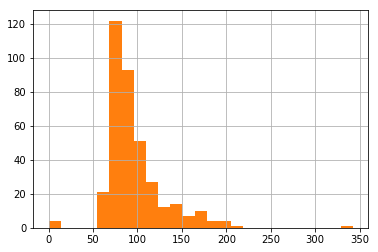

In [22]:
import matplotlib.pyplot as plt
tas['est_trip_seconds'].hist(bins = 25)
plt.show()